# <font color='deeppink'><b> Actor-Critic in Reinforcement Learning </b></font>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical
import random
import gym
import time 
import numpy as np
import torchplot as tp
from itertools import count
from collections import namedtuple
from circuit.vcamp import VCAmpRLEnvDiscrete
import math

# Plots 
import matplotlib.pyplot as plt

# Setting a fixed seed for reproducible results
np.random.seed(seed=12)
torch.manual_seed(seed=12)


#import pygame
#from pygame import gfxdraw

<string>:2: DeprecationWarning: invalid escape sequence \m
<string>:2: DeprecationWarning: invalid escape sequence \ 
<string>:2: DeprecationWarning: invalid escape sequence \l
<string>:2: DeprecationWarning: invalid escape sequence \s


In [2]:
# Create the environment
env = VCAmpRLEnvDiscrete()

c:\Users\tomas\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

In [4]:
print("There are {} actions".format(env.action_size))
print(env.reset().shape)


There are 36 actions
(23,)


In [5]:
# Network: Actor-Critic 
#     
# First fully connected layer with 23 inputs (states) and 256 outputs (arbitrary number)
# 
# 
# 
# 
# 


class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.common1 = torch.nn.Linear(23, 256) # 4 because there are 4 parameters as the observation space
        self.common2 = torch.nn.Linear(256,128)
        
        self.actor = torch.nn.Linear(128, 36) # 72 for the number of actions

        self.fc3 = torch.nn.Linear(128,50)
        self.critic = torch.nn.Linear(50, 1) # Critic is always 1
        
        self.saved_actions = []
        self.rewards = []
        
    def forward(self, x):
        x = torch.sigmoid(self.common1(x))
        x = torch.sigmoid(self.common2(x))

        action_scores = self.actor(x)
        
        #print(f"{x= }")
        #print(f"{action_scores= }")
        action_prob = F.softmax(action_scores, dim=-1)

        
        state_values = F.softmax(self.fc3(x), dim=-1)
        state_values = self.critic(state_values)
        
        return action_prob, state_values
       

In [6]:
action_space_size = env.action_size
state_space_size = env.obs.shape[0]

# Lists for plotting
episode_list = []
reward_list = []
loss_list = []


In [7]:
learning_rate = 3e-5

model = ActorCritic()
optimizer = optim.AdamW(model.parameters(), learning_rate)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

In [8]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model.forward(state)

    # flag = random()
  
    # exploration_rate_threshold = random.uniform(0,1)
    # print(len(probs), len(state_value))

    # print(state)
    # print(probs)

    # probs = math.log(probs)

    m = Categorical(probs)
 
    action = m.sample()

    # print("Action: " , action)   


    # else:
    # while action.item() != 1 and action.item() != 3 and action.item() != 5\
    #         and action.item() != 7 and action.item() != 12 and action.item() != 14 \
    #              and action.item() != 21 and action.item() != 26 and action.item() != 27 :
    #     print(action.item())
    #     action = torch.tensor(env.sample_action())
        # print(action.item())


    # perform one action and assess the results

    # action = torch.tensor(env.sample_action())
    # print(action)
    
    # print("Chosen Action: ", action.item())


    # print(action.item())
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    
    return action.item()


In [9]:
def finish_episode():
    
    # We calculate the losses and perform backprop in this function
    R = 0
    actor_losses = []
    critic_losses = []
    saved_actions = model.saved_actions
    returns = []
    gamma = 0.99 #Discount factor for past rewards
    

    # Calculate expected value from rewards
    # - At each timestep what's the total reward received after that timestep
    # - Rewards in the past are discounted by multiplying them with gamma
    # - These are the labels for our critic
    # - R: Past Rewards
    # - r: total Reward
    for r in model.rewards[::-1]:
        R = r + gamma * R 
        returns.insert(0, R)
        # print(returns)


    # R é return real
    # value é o retorno do crítico


    if len(returns) <= 1:
        returns = torch.tensor([0.0])
        
    # Normalize
    else: 
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

    # print("model rewards" , model.rewards)
    # print("Returns " , returns)
    # print("Saved action" ,saved_actions)


    # Critic train
    for (log_prob, value), R in zip(saved_actions, returns):
        # At this point in history, the critic estimated that we would get a
        # total reward = `value` in the future. We took an action with log probability
        # of `log_prob` and ended up recieving a total reward = `ret`.
        # The actor must be updated so that it predicts an action that leads to
        # high rewards (compared to critic's estimate) with high probability.
        advantage = R - value.item()   
        actor_losses.append(-log_prob * advantage) # Actor Loss
        

        # The critic must be updated so that it predicts a 
        # better estimate of future rewards.
        critic_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

        # print("Log_prob: ", log_prob)



    optimizer.zero_grad()

    # BackPropagation
    loss = torch.stack(actor_losses).sum() + torch.stack(critic_losses).sum()
    loss_list.append(loss)
    loss.backward()
    
    # Gradient Clipping
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm= 5)
    
    # print("----------------------------------------------------------GRADIENTS-----------------------------------------------\n")
    # for p in model.parameters():
        #print(p.grad.norm())
        #print(loss)
    optimizer.step()
    
    # Clear the loss and reward history
    del model.rewards[:]
    del model.saved_actions[:]


In [10]:
# Pretty Colors for plots

Colors = ['mediumaquamarine', 'blueviolet', 'lightcoral',
            'darkorange', 'royalblue', 'crimson', 'dimgray',
            'navy', 'violet', 'teal', 'hotpink', 'peru']


In [11]:
def plot_reward(episode_list, reward_list, intervals=None):
  
    n_ep = len(episode_list)

    if intervals is None:
        intervals = [[0, n_ep]]

    for i, [l, r] in enumerate(intervals):
        plt.plot(episode_list[max(0,l):min(r,n_ep)], reward_list[max(0,l):min(r,n_ep)], color=Colors[i])
        print(l, r)
    
    plt.xlabel('x - # Episode')
    plt.ylabel('y - Reward')
    plt.title('Reward over episodes')
    # plt.xscale('log')
    # plt.xscale('log')
    plt.grid()
    plt.show()

In [12]:
def plot_losses(episode_list, loss_list):

    tp.plot(episode_list, loss_list)
    tp.xlabel('x - # Episode')
    tp.ylabel('y - Loss')
    tp.title('Losses over episodes')
    tp.grid()
    tp.show()

In [13]:
def train():
    running_reward = 1
    episode_list = []
    reward_list = []
    t_max = 1000
   
    for i_episode in count(): # We need around this much episodes
        state = env.reset(env.values_init)
        ep_reward = 0
        reward_improvement = 0 
        # print(state)
        # print(probs)
       

        for t in range(1, t_max):
            # print(t, end=', \n')

            action = select_action(state)                   # Action is selected
            state, reward, done, log = env.step(action)     # State is updated accordingly
            
            # print(reward)
            # print(action)


            model.rewards.append(reward)
            # print(model.rewards)
            if i_episode > 0:
                if model.rewards[t-2] < model.rewards[t-1]:
                        reward_improvement = model.rewards[t-1] - model.rewards[t-2]
                        # print("# Action:",action, "Improvement:", reward_improvement)



            ep_reward = reward
        

            
            if done:
                break
        
        

        # Breaking conditions in case it does not find a solution that fits the requirements
        if i_episode == 5000:
            break


        # Update running reward to check condition for solving
        running_reward = 0.05 * ep_reward + (1-0.05) * running_reward


        # Additional lists for plotting
        episode_list.append(i_episode)
        reward_list.append(running_reward) 


        finish_episode()

        # exploration_rate = min_exploration_rate + \
            # (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*i_episode)




        if i_episode: # % 2 == 0: # We will print some things out
            print("------------------------Episode {}\tLast Reward: {:.3f}\tRunning reward: {:.3f}---------------------------------------------\n---------------------------------------------\n---------------------------------------------\n---------------------------------------------\n---------------------------------------------\n".format(
                i_episode, ep_reward, running_reward
            ))
            # print(log)
            
        if running_reward >= 10:
            print("Solved, running reward is now {} and the last episode runs to {} time steps".format(
                    running_reward, t
            ))
            break
           
    plot_reward(episode_list, reward_list, [[0,100],[99,300],[299,500],[499,1000],[999,1500],[1499,3000],[2999,4000],[3999,5000],[4999,6000]])
    plot_losses(episode_list[0:i_episode], loss_list)
    # plot_value_losses(episode_list, value_losses)
   

In [14]:
train()

------------------------Episode 1	Last Reward: -6.786	Running reward: 0.478---------------------------------------------
---------------------------------------------
---------------------------------------------
---------------------------------------------
---------------------------------------------

------------------------Episode 2	Last Reward: -1.331	Running reward: 0.387---------------------------------------------
---------------------------------------------
---------------------------------------------
---------------------------------------------
---------------------------------------------

------------------------Episode 3	Last Reward: -2.492	Running reward: 0.243---------------------------------------------
---------------------------------------------
---------------------------------------------
---------------------------------------------
---------------------------------------------

------------------------Episode 4	Last Reward: -3.372	Running reward: 0.062-------

c:\Users\tomas\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 100
99 300
299 500
499 1000
999 1500
1499 3000
2999 4000
3999 5000
4999 6000


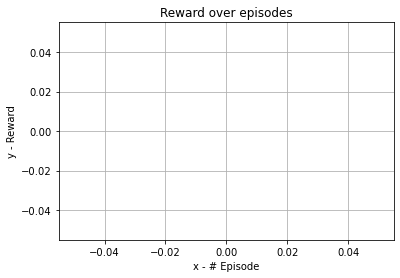

In [ ]:
env._run_simulation()
env.measures

{'gdc': 48.85422,
 'gbw': 2520056.0,
 'pm': 89.4101,
 'inoise_total': 0.0003150038,
 'onoise_total': 0.005124187,
 'output': '-4.541336100505333e-06',
 'in_p': '1.650000000000000e+00',
 'in_n': '1.650000000000000e+00',
 'm_xinova_mpm0_vgs': '6.524639154544216e-01',
 'm_xinova_mpm0_vth': '4.467914444126588e-01',
 'm_xinova_mpm0_vds': '1.901233546044157e+00',
 'm_xinova_mpm0_vdsat': '2.037537391357075e-01',
 'm_xinova_mpm0_id': '3.574278987112031e-06',
 'm_xinova_mpm1_vgs': '6.524639154543399e-01',
 'm_xinova_mpm1_vth': '4.466245457108232e-01',
 'm_xinova_mpm1_vds': '6.524639154543723e-01',
 'm_xinova_mpm1_vdsat': '2.056832422574022e-01',
 'm_xinova_mpm1_id': '3.161927821147274e-05',
 'm_xinova_mpm2_vgs': '6.524638629115840e-01',
 'm_xinova_mpm2_vth': '4.466245457335640e-01',
 'm_xinova_mpm2_vds': '6.524638629116537e-01',
 'm_xinova_mpm2_vdsat': '2.056832012166709e-01',
 'm_xinova_mpm2_id': '3.161926436642539e-05',
 'm_xinova_mpm3_vgs': '6.524638629117030e-01',
 'm_xinova_mpm3_vth': '4.4

In [ ]:
# There. we finished
# Lets see it in action
done = False
cnt = 0

In [ ]:
observation = env.reset()
while True:
    cnt += 1
    env.render()
    action = select_action(observation)
    observation, reward, done, _ = env.step(action)
    # Lets see how long it lasts until failing
print(f"Game lasted {cnt} moves")

Values:
 [ 9.4000e-05  8.5000e-05  1.0000e-06  5.3000e-05  5.6000e-05  4.9000e-05
  8.0000e-07  4.0000e-07  8.0000e-07  4.0000e-07  4.0000e-07  4.0000e-07
  2.0970e+03  5.1030e+03 -7.1390e+03 -1.2978e+04  1.7620e+03  2.1640e+03]
Performance: -118.82298099760457
Eval Log: {'idd_lt': (0.00035, 0.04152209985360605), 'pm_lt': (90.0, 90.09535), 'gdc_gt': (50, 30.01092), 'gbw_gt': (35000000.0, 7435087.0)}
Values:
 [ 9.4000e-05  8.5000e-05  1.0000e-06  5.3000e-05  5.7000e-05  4.9000e-05
  8.0000e-07  4.0000e-07  8.0000e-07  4.0000e-07  4.0000e-07  4.0000e-07
  2.0970e+03  5.1030e+03 -7.1390e+03 -1.2978e+04  1.7620e+03  2.1640e+03]
Performance: -118.82225774255677
Eval Log: {'idd_lt': (0.00035, 0.04152209985360605), 'pm_lt': (90.0, 90.09535), 'gdc_gt': (50, 30.01092), 'gbw_gt': (35000000.0, 7435087.0)}
Values:
 [ 9.3000e-05  8.5000e-05  1.0000e-06  5.3000e-05  5.7000e-05  4.9000e-05
  8.0000e-07  4.0000e-07  8.0000e-07  4.0000e-07  4.0000e-07  4.0000e-07
  2.0970e+03  5.1030e+03 -7.1390e+03 -1

KeyboardInterrupt: 